Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import joblib

Simple GNN architecture, can scale up later

In [2]:
class KneePointGCN(nn.Module):
    def __init__(self, features=10, output_channels=2):
        super(KneePointGCN, self).__init__()
        self.conv1 = GCNConv(features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.final_layer = nn.Linear(16, output_channels)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.final_layer(x)
        return x

load data and create feature matrix

**Dataset is loaded by treating ZrO2 and YSZ as different material types**

In [3]:
data_df = pd.read_csv('./data/master_dataframe.csv')
label_encoder = LabelEncoder()
scaler = MinMaxScaler()
data_df['Material_encoded'] = label_encoder.fit_transform(data_df['Material'])
print(pd.get_dummies(data_df['Material']))
data_df = pd.concat([data_df, pd.get_dummies(data_df['Material']).astype(float)], axis=1)

node_features = []
node_labels = []

for material, group_df in data_df.groupby('Material'):

    group_df = group_df.sort_values('Electric_Field(V/cm)').reset_index(drop=True)
    
    sub_node_features = group_df[['Al2O3', 'BaTiO3', 'CoMnO4', 'SiC', 'SrTiO3',
       'TiO2', 'Y2O3', 'YSZ', 'ZrO2', 'Electric_Field(V/cm)']].values
       
    sub_node_labels = group_df[['Knee_Temp(1000/T)', 'Knee_PW(mW/mm^3)']].values

    node_features.append(sub_node_features)
    node_labels.append(sub_node_labels)

node_features = np.concatenate(node_features, axis=0)
node_labels = np.concatenate(node_labels, axis=0)
    
print(node_features.shape)
print(node_labels.shape)


    Al2O3  BaTiO3  CoMnO4    SiC  SrTiO3   TiO2   Y2O3    YSZ   ZrO2
0    True   False   False  False   False  False  False  False  False
1    True   False   False  False   False  False  False  False  False
2   False    True   False  False   False  False  False  False  False
3   False    True   False  False   False  False  False  False  False
4   False    True   False  False   False  False  False  False  False
5   False    True   False  False   False  False  False  False  False
6   False   False    True  False   False  False  False  False  False
7   False   False    True  False   False  False  False  False  False
8   False   False    True  False   False  False  False  False  False
9   False   False    True  False   False  False  False  False  False
10  False   False   False   True   False  False  False  False  False
11  False   False   False  False    True  False  False  False  False
12  False   False   False  False    True  False  False  False  False
13  False   False   False  False  

split dataset into train, validation and test dataset (64,16,20) and normalize

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(node_features, node_labels, test_size=0.2, shuffle=True, random_state=5)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, shuffle=True, random_state=5)

scaler = MinMaxScaler()
scaler.fit(train_features[:, -1].reshape(-1, 1))

train_features[:, -1] = scaler.transform(train_features[:, -1].reshape(-1, 1)).ravel()
val_features[:, -1]   = scaler.transform(val_features[:, -1].reshape(-1, 1)).ravel()
test_features[:, -1]  = scaler.transform(test_features[:, -1].reshape(-1, 1)).ravel()

train_features = torch.from_numpy(train_features).float()
train_labels   = torch.from_numpy(train_labels).float()

val_features   = torch.from_numpy(val_features).float()
val_labels     = torch.from_numpy(val_labels).float()

test_features  = torch.from_numpy(test_features).float()
test_labels    = torch.from_numpy(test_labels).float()

Construct subgraphs based on the material type of the dataset, forming a linear graph. Nodes are connected to its neighboring node linearly based on the ascending order of the electric field value.

In [5]:
train_edges = []
test_edges = []
val_edges = []

sorted_materials = []
# create train_edges_index
for i in range(len(train_features)):
    material = train_features[i][:-1]
    e = train_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(train_features)):
            if train_features[j][-1].item() != e and torch.equal(material, train_features[j][:-1]):
                same_materials.append([j, train_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        train_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])


sorted_materials = []
# create val_edges_index
for i in range(len(val_features)):
    material = val_features[i][:-1]
    e = val_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(val_features)):
            if val_features[j][-1].item() != e and torch.equal(material, val_features[j][:-1]):
                same_materials.append([j, val_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        val_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])


sorted_materials = []
# create test_edges_index
for i in range(len(test_features)):
    material = test_features[i][:-1]
    e = test_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(test_features)):
            if test_features[j][-1].item() != e and torch.equal(material, test_features[j][:-1]):
                same_materials.append([j, test_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        test_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])

train_edges  = to_undirected(torch.tensor(train_edges).t())
test_edges = to_undirected(torch.tensor(test_edges).t())
val_edges = to_undirected(torch.tensor(val_edges).t())


Fully connected graph construction
### NOT USED!

In [8]:
train_edges = []
test_edges = []
val_edges = []
sorted_materials = []

# create train_edges_index
for i in range(len(train_features)):
    material = train_features[i][:-1]
    e = train_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(train_features)):
            if train_features[j][-1].item() != e and torch.equal(material, train_features[j][:-1]):
                same_materials.append([j, train_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield)):
        source = sorted_based_on_electricfield[n][0]
        for m in range(len(sorted_based_on_electricfield)):
            if m != n:
                train_edges.append([source, sorted_based_on_electricfield[m][0]])

sorted_materials = []
# create test_edges_index
for i in range(len(test_features)):
    material = test_features[i][:-1]
    e = test_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(test_features)):
            if test_features[j][-1].item() != e and torch.equal(material, test_features[j][:-1]):
                same_materials.append([j, test_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield)):
        source = sorted_based_on_electricfield[n][0]
        for m in range(len(sorted_based_on_electricfield)):
            if m != n:
                test_edges.append([source, sorted_based_on_electricfield[m][0]])

sorted_materials = []
# create val_edges_index
for i in range(len(val_features)):
    material = val_features[i][:-1]
    e = val_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(val_features)):
            if val_features[j][-1].item() != e and torch.equal(material, val_features[j][:-1]):
                same_materials.append([j, val_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield)):
        source = sorted_based_on_electricfield[n][0]
        for m in range(len(sorted_based_on_electricfield)):
            if m != n:
                val_edges.append([source, sorted_based_on_electricfield[m][0]])

train_edges  = to_undirected(torch.tensor(train_edges).t())
test_edges = to_undirected(torch.tensor(test_edges).t())
val_edges = to_undirected(torch.tensor(val_edges).t())

Create train test validation dataloader

In [6]:
train_data = Data(x=train_features, edge_index=train_edges, y=train_labels)
val_data = Data(x=val_features, edge_index=val_edges, y=val_labels)
test_data = Data(x=test_features, edge_index=test_edges, y= test_labels)

Visualize the constructed graph

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


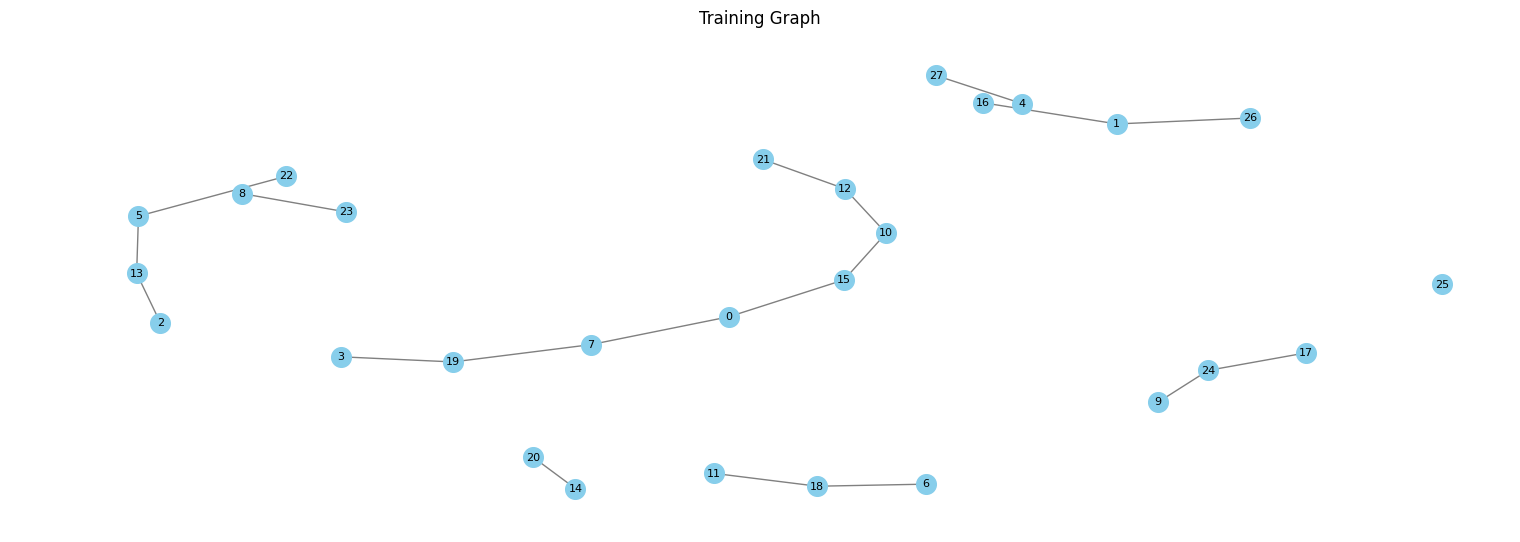

[0, 1, 2, 3, 4, 5, 6, 7, 8]


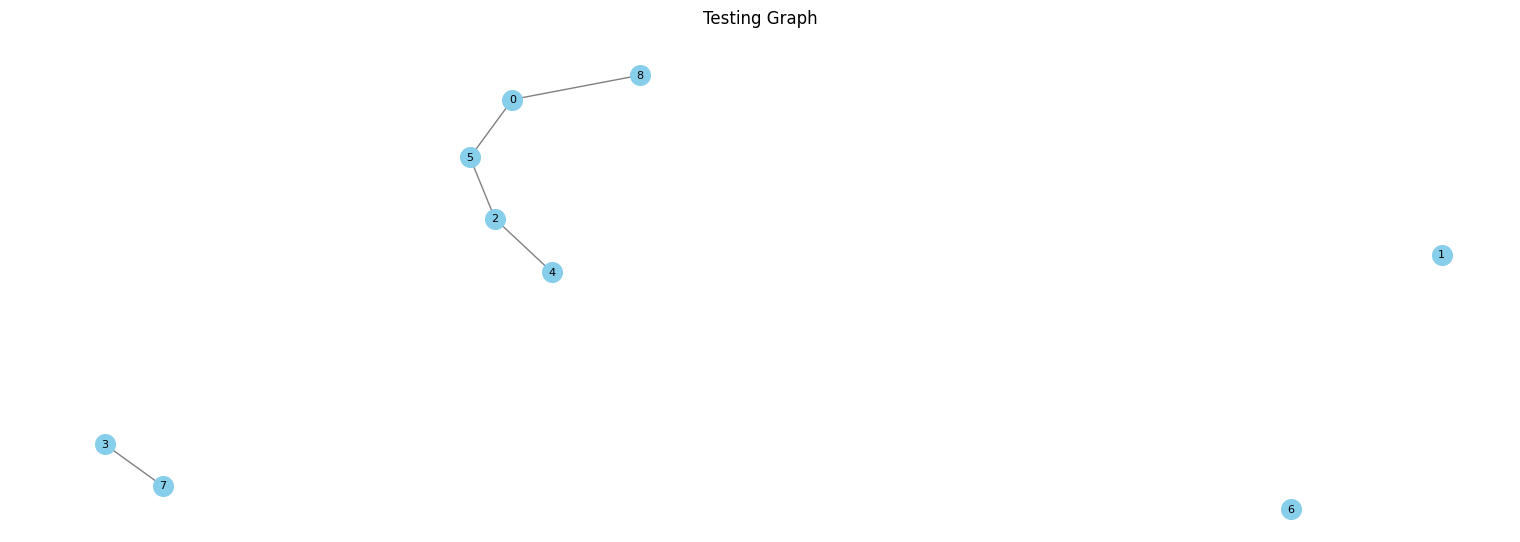

[0, 1, 2, 3, 4, 5, 6]


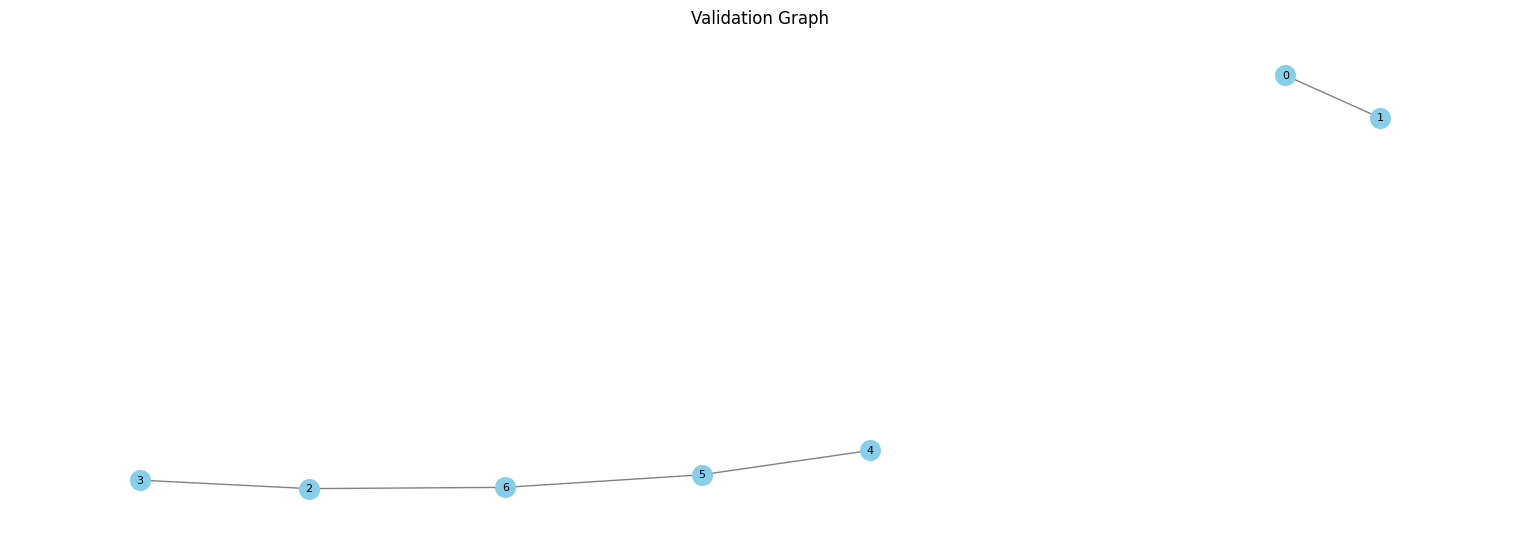

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph_data, title="Graph Visualization"):
    """
    Function to visualize a PyG graph using NetworkX.
    """
    # Convert PyG graph to NetworkX format
    G = to_networkx(graph_data, to_undirected=True)
    print(G.nodes)
    # Set figure size
    plt.figure(figsize=(15, 5))

    pos = nx.spring_layout(G, seed=42, k=0.4)  # `k` adjusts node spacing
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=200, font_size=8)

    # Set title
    plt.title(title)
    plt.show()

# Visualizing Train Graph
visualize_graph(train_data, title="Training Graph")

# Visualizing Test Graph
visualize_graph(test_data, title="Testing Graph")

visualize_graph(val_data, title="Validation Graph")


Train function

In [8]:
def train(model, train_data, val_data, test_data, optimizer, loss_fn, epochs):
    history = {
        'train_losses': [],
        'test_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'val_accuracies': []
    }
    for epoch in range(epochs):
        # Begin training
        model.train()
        optimizer.zero_grad()
        output = model(train_data.x, train_data.edge_index)

        percentage_error = torch.abs((output - train_data.y) / (train_data.y + 1e-8)) * 100
        mape = percentage_error.mean().item()
        epoch_accuracy = 100 - mape
        history['train_accuracies'].append(epoch_accuracy)
        loss = loss_fn(output, train_data.y)
        history['train_losses'].append(loss.item())
     
        loss.backward()
        optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {epoch_accuracy}%')

        # Begin Validation
        model.eval()
        with torch.inference_mode():
            val_output = model(val_data.x, val_data.edge_index)
            percentage_error = torch.abs((val_output - val_data.y) / (val_data.y + 1e-8)) * 100
            val_mape = percentage_error.mean().item()
            val_accuracy = 100 - val_mape
            history['val_accuracies'].append(val_accuracy)
            val_loss = loss_fn(val_output, val_data.y)
            history['val_losses'].append(val_loss.item())
        print(f'Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}%')
    
    model.eval()
    with torch.inference_mode():
        test_output = model(test_data.x, test_data.edge_index)

        percentage_error = torch.abs((test_output - test_data.y) / (test_data.y + 1e-8)) * 100
        test_mape = percentage_error.mean().item()
        test_accuracy = 100 - test_mape
        history['test_accuracies'].append(test_accuracy)
        test_loss = loss_fn(test_output, test_data.y)
        history['test_losses'].append(test_loss.item())
    print(f'Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}%')
    return history

plot loss & accuracy function

In [9]:
def plot_losses(epochs, training_losses, training_accuracies, test_accuracies, test_losses, val_losses, val_accuracies, save_path):  
    fig, ax = plt.subplots(2, 1, figsize=(40, 20))
    ax[0].plot(range(epochs), training_losses, label='Training Loss', color='blue')
    ax[0].plot(range(epochs), val_losses, label='Validation Loss', color='green')
    ax[0].legend()
    ax[1].plot(range(epochs), training_accuracies, label='Training Accuracy', color='blue')
    ax[1].plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
    ax[1].legend()
    if save_path is not None:
        plt.savefig(save_path + '/loss_figure.png')
    else:
        plt.show()

## Training and evaluating loss & accuracy

Epoch 1/350, Train Loss: 14.945164680480957, Train Accuracy: 16.471153259277344%
Val Loss: 15.943255424499512, Val Accuracy: 12.120124816894531%
Epoch 2/350, Train Loss: 14.910664558410645, Train Accuracy: 17.827651977539062%
Val Loss: 15.917539596557617, Val Accuracy: 12.861701965332031%
Epoch 3/350, Train Loss: 14.87394905090332, Train Accuracy: 19.314743041992188%
Val Loss: 15.889199256896973, Val Accuracy: 13.654563903808594%
Epoch 4/350, Train Loss: 14.8342924118042, Train Accuracy: 20.90906524658203%
Val Loss: 15.856925010681152, Val Accuracy: 14.657470703125%
Epoch 5/350, Train Loss: 14.789631843566895, Train Accuracy: 22.773399353027344%
Val Loss: 15.821236610412598, Val Accuracy: 15.82635498046875%
Epoch 6/350, Train Loss: 14.740097045898438, Train Accuracy: 24.94286346435547%
Val Loss: 15.782257080078125, Val Accuracy: 17.16735076904297%
Epoch 7/350, Train Loss: 14.682682991027832, Train Accuracy: 27.578201293945312%
Val Loss: 15.73885440826416, Val Accuracy: 18.7181243896484

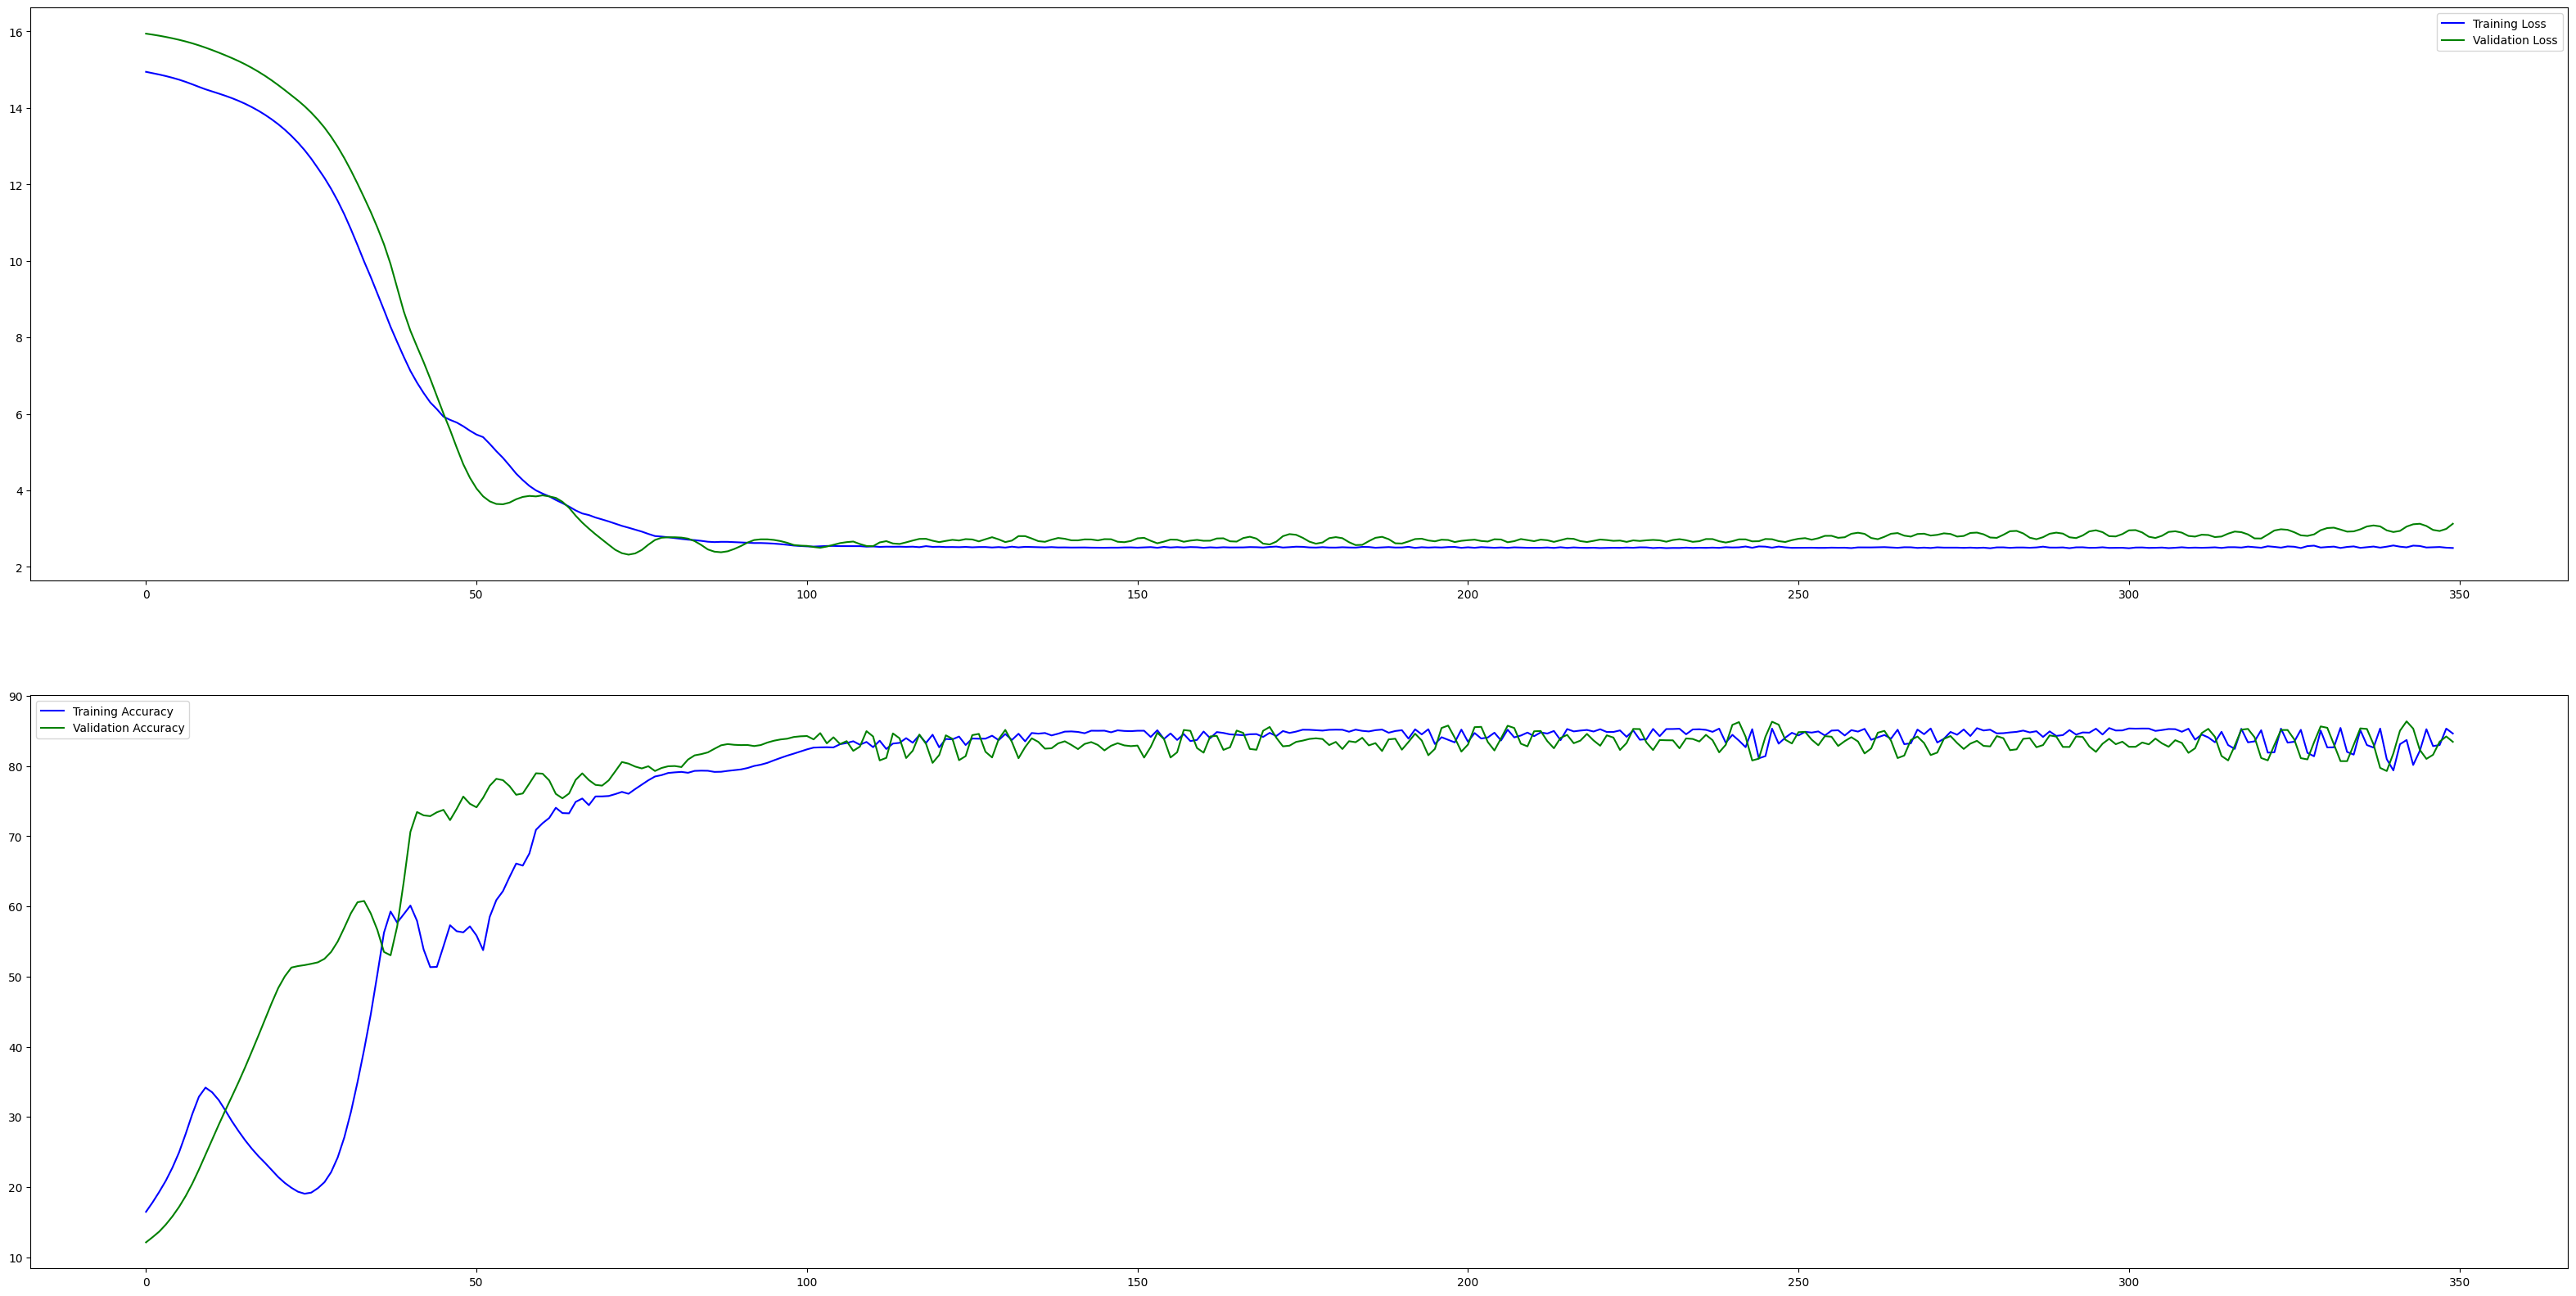

In [18]:
# Train the model
model = KneePointGCN(features=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.L1Loss()
epochs = 350
hist = train(model=model, train_data=train_data, val_data=val_data, test_data=test_data, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs)
plot_losses(training_losses=hist['train_losses'], training_accuracies=hist['train_accuracies'], test_accuracies=hist['test_accuracies'], test_losses=hist['test_losses'], val_accuracies=hist['val_accuracies'], val_losses=hist['val_losses'], epochs=epochs, save_path='/home/sgl57/CSE_MSE_RXF131/cradle-members/mds3/sgl57/24-ceramics-rishi/topics/GNN')

**Now reload the dataset, Categorize ZrO2 and YSZ as the same material type, adding their subgraph together in the graph construction to find its effects on model's learning performances**

In [19]:
data_df = pd.read_csv('./data/master_dataframe.csv')
label_encoder = LabelEncoder()
scaler = MinMaxScaler()
data_df['Material'] = data_df['Material'].replace('ZrO2', 'YSZ')
data_df['Material_encoded'] = label_encoder.fit_transform(data_df['Material'])
print(pd.get_dummies(data_df['Material']))
data_df = pd.concat([data_df, pd.get_dummies(data_df['Material']).astype(float)], axis=1)

node_features = []
node_labels = []

for material, group_df in data_df.groupby('Material'):

    group_df = group_df.sort_values('Electric_Field(V/cm)').reset_index(drop=True)
    
    sub_node_features = group_df[['Al2O3', 'BaTiO3', 'CoMnO4', 'SiC', 'SrTiO3',
       'TiO2', 'Y2O3', 'YSZ', 'Electric_Field(V/cm)']].values
       
    sub_node_labels = group_df[['Knee_Temp(1000/T)', 'Knee_PW(mW/mm^3)']].values

    node_features.append(sub_node_features)
    node_labels.append(sub_node_labels)

node_features = np.concatenate(node_features, axis=0)
node_labels = np.concatenate(node_labels, axis=0)
    
print(node_features.shape)
print(node_labels.shape)

    Al2O3  BaTiO3  CoMnO4    SiC  SrTiO3   TiO2   Y2O3    YSZ
0    True   False   False  False   False  False  False  False
1    True   False   False  False   False  False  False  False
2   False    True   False  False   False  False  False  False
3   False    True   False  False   False  False  False  False
4   False    True   False  False   False  False  False  False
5   False    True   False  False   False  False  False  False
6   False   False    True  False   False  False  False  False
7   False   False    True  False   False  False  False  False
8   False   False    True  False   False  False  False  False
9   False   False    True  False   False  False  False  False
10  False   False   False   True   False  False  False  False
11  False   False   False  False    True  False  False  False
12  False   False   False  False    True  False  False  False
13  False   False   False  False    True  False  False  False
14  False   False   False  False   False   True  False  False
15  Fals

Split the dataset into train test validation dataset (64/16/20)

In [20]:
train_features, test_features, train_labels, test_labels = train_test_split(node_features, node_labels, test_size=0.2, shuffle=True, random_state=5)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, shuffle=True, random_state=5)

scaler = MinMaxScaler()
scaler.fit(train_features[:, -1].reshape(-1, 1))

train_features[:, -1] = scaler.transform(train_features[:, -1].reshape(-1, 1)).ravel()
val_features[:, -1]   = scaler.transform(val_features[:, -1].reshape(-1, 1)).ravel()
test_features[:, -1]  = scaler.transform(test_features[:, -1].reshape(-1, 1)).ravel()

train_features = torch.from_numpy(train_features).float()
train_labels   = torch.from_numpy(train_labels).float()

val_features   = torch.from_numpy(val_features).float()
val_labels     = torch.from_numpy(val_labels).float()

test_features  = torch.from_numpy(test_features).float()
test_labels    = torch.from_numpy(test_labels).float()

Construct subgraphs based on the material type of the dataset, forming a linear graph, edges are connected based on the electric field value.

In [21]:
train_edges = []
test_edges = []
val_edges = []

sorted_materials = []
# create train_edges_index
for i in range(len(train_features)):
    material = train_features[i][:-1]
    e = train_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(train_features)):
            if train_features[j][-1].item() != e and torch.equal(material, train_features[j][:-1]):
                same_materials.append([j, train_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        train_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])


sorted_materials = []
# create val_edges_index
for i in range(len(val_features)):
    material = val_features[i][:-1]
    e = val_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(val_features)):
            if val_features[j][-1].item() != e and torch.equal(material, val_features[j][:-1]):
                same_materials.append([j, val_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        val_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])


sorted_materials = []
# create test_edges_index
for i in range(len(test_features)):
    material = test_features[i][:-1]
    e = test_features[i][-1].item()
    same_materials = []
    seen = False
    for m in sorted_materials:
        if torch.equal(m, material):
            seen = True
            break
    if not seen:
        for j in range(i, len(test_features)):
            if test_features[j][-1].item() != e and torch.equal(material, test_features[j][:-1]):
                same_materials.append([j, test_features[j][-1].item()])
        same_materials.append([i, e])
        sorted_materials.append(material)
    
    sorted_based_on_electricfield = sorted(same_materials, key=lambda a: a[1])

    for n in range(len(sorted_based_on_electricfield) - 1):
        test_edges.append([sorted_based_on_electricfield[n][0], sorted_based_on_electricfield[n + 1][0]])

train_edges  = to_undirected(torch.tensor(train_edges).t())
test_edges = to_undirected(torch.tensor(test_edges).t())
val_edges = to_undirected(torch.tensor(val_edges).t())


Create Train Validation Test dataloader

In [22]:
train_data = Data(x=train_features, edge_index=train_edges, y=train_labels)
val_data = Data(x=val_features, edge_index=val_edges, y=val_labels)
test_data = Data(x=test_features, edge_index=test_edges, y= test_labels)

Visualize Constructed graphs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


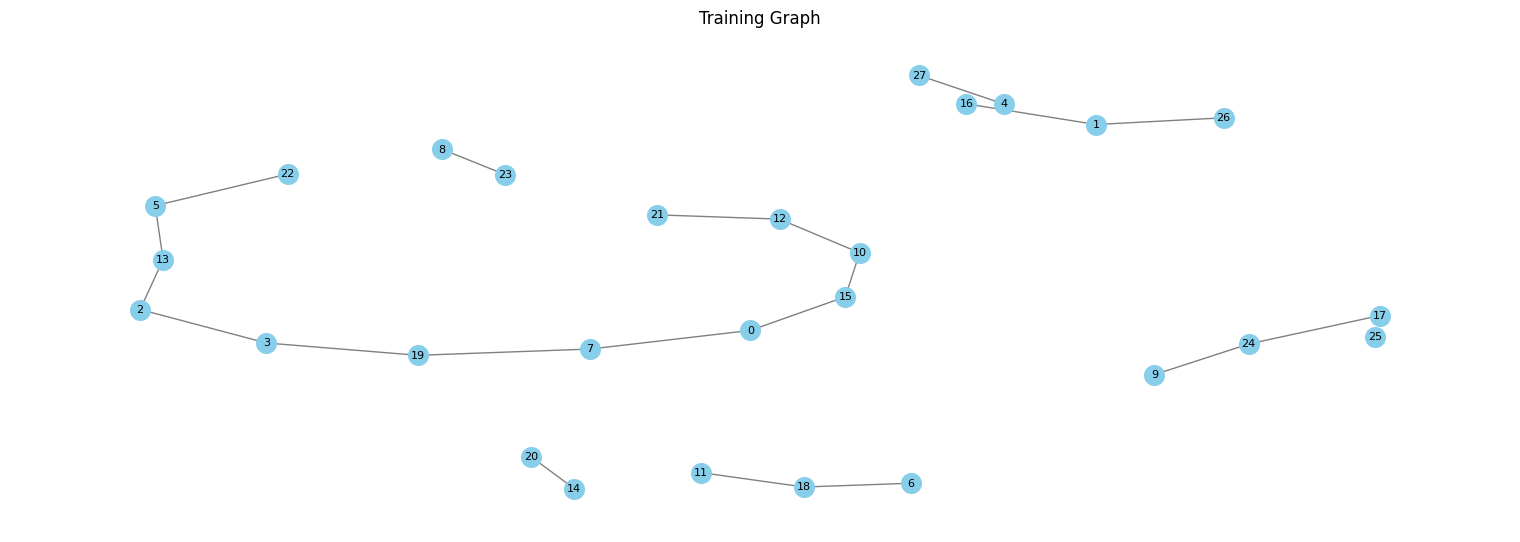

[0, 1, 2, 3, 4, 5, 6, 7, 8]


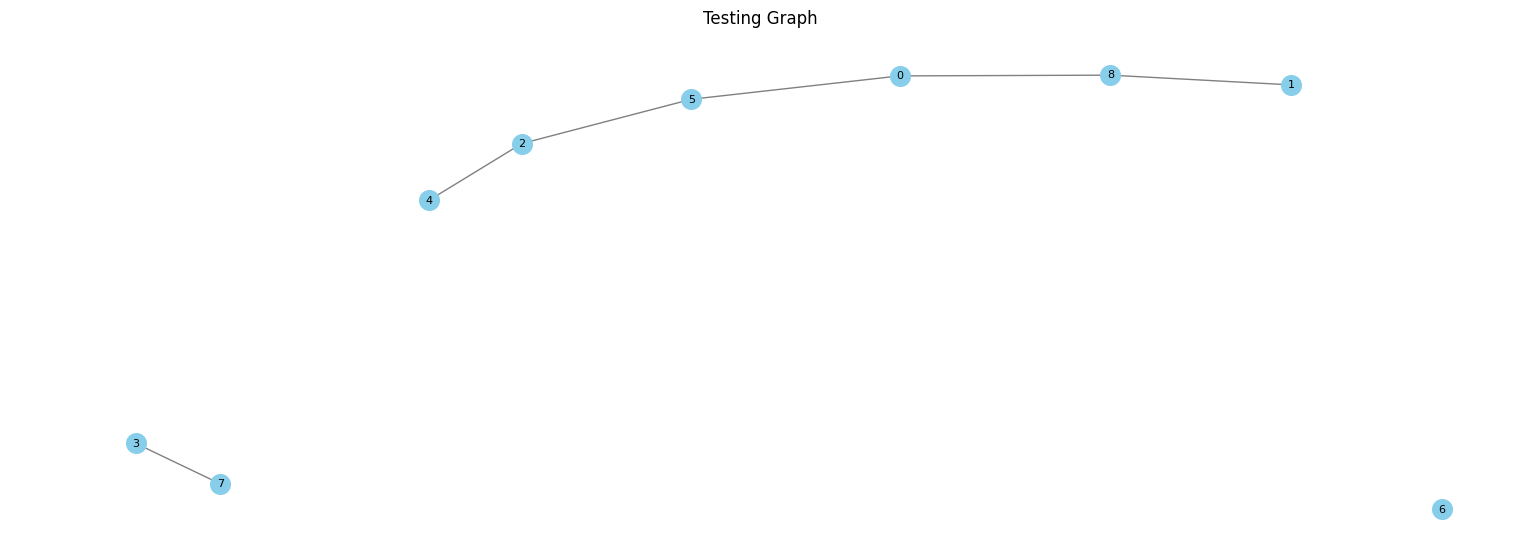

[0, 1, 2, 3, 4, 5, 6]


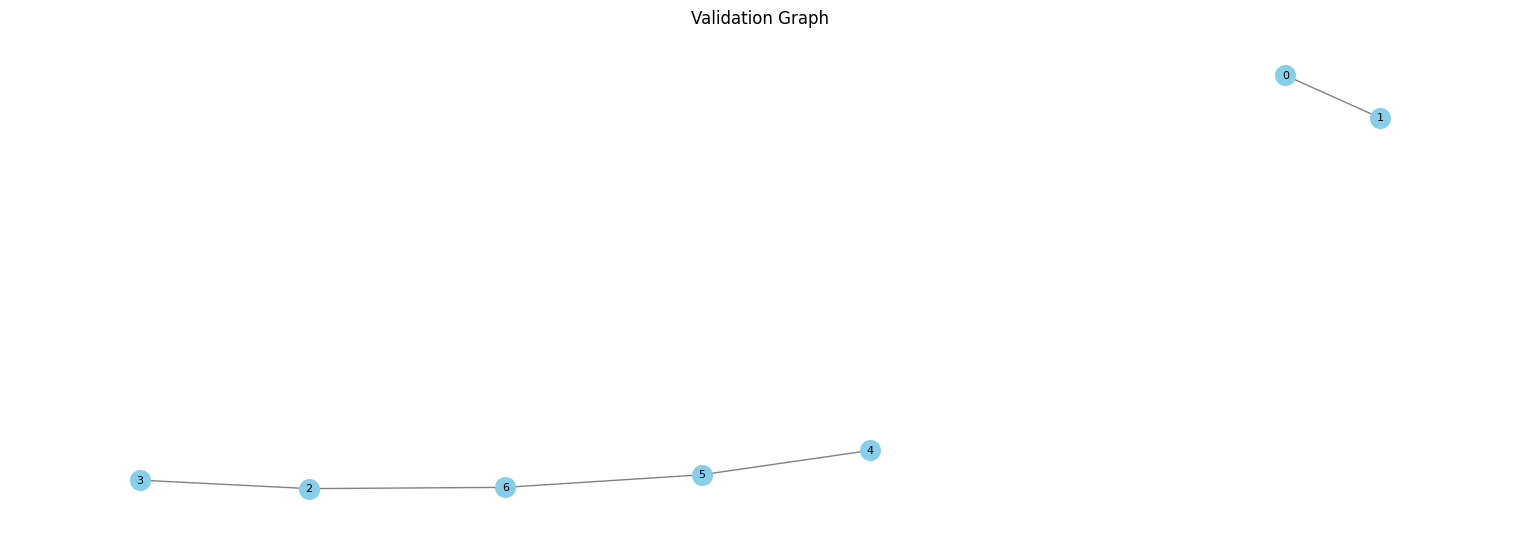

In [23]:
# Visualizing Train Graph
visualize_graph(train_data, title="Training Graph")

# Visualizing Test Graph
visualize_graph(test_data, title="Testing Graph")

visualize_graph(val_data, title="Validation Graph")

### Retrain the model with combined ZrO2 and YSZ subgraphs, evaluate loss & accuracy

Epoch 1/350, Train Loss: 16.669139862060547, Train Accuracy: -3.8474502563476562%
Val Loss: 11.048789024353027, Val Accuracy: -3.2708358764648438%
Epoch 2/350, Train Loss: 16.65043067932129, Train Accuracy: -2.8142776489257812%
Val Loss: 11.032238960266113, Val Accuracy: -2.3810348510742188%
Epoch 3/350, Train Loss: 16.63362693786621, Train Accuracy: -2.0247650146484375%
Val Loss: 11.01385498046875, Val Accuracy: -1.5558547973632812%
Epoch 4/350, Train Loss: 16.617061614990234, Train Accuracy: -1.34375%
Val Loss: 10.994303703308105, Val Accuracy: -0.8445205688476562%
Epoch 5/350, Train Loss: 16.59972381591797, Train Accuracy: -0.7969818115234375%
Val Loss: 10.973759651184082, Val Accuracy: -0.1854705810546875%
Epoch 6/350, Train Loss: 16.580944061279297, Train Accuracy: -0.26220703125%
Val Loss: 10.951202392578125, Val Accuracy: 0.54376220703125%
Epoch 7/350, Train Loss: 16.5598201751709, Train Accuracy: 0.3362884521484375%
Val Loss: 10.926203727722168, Val Accuracy: 1.3615951538085938

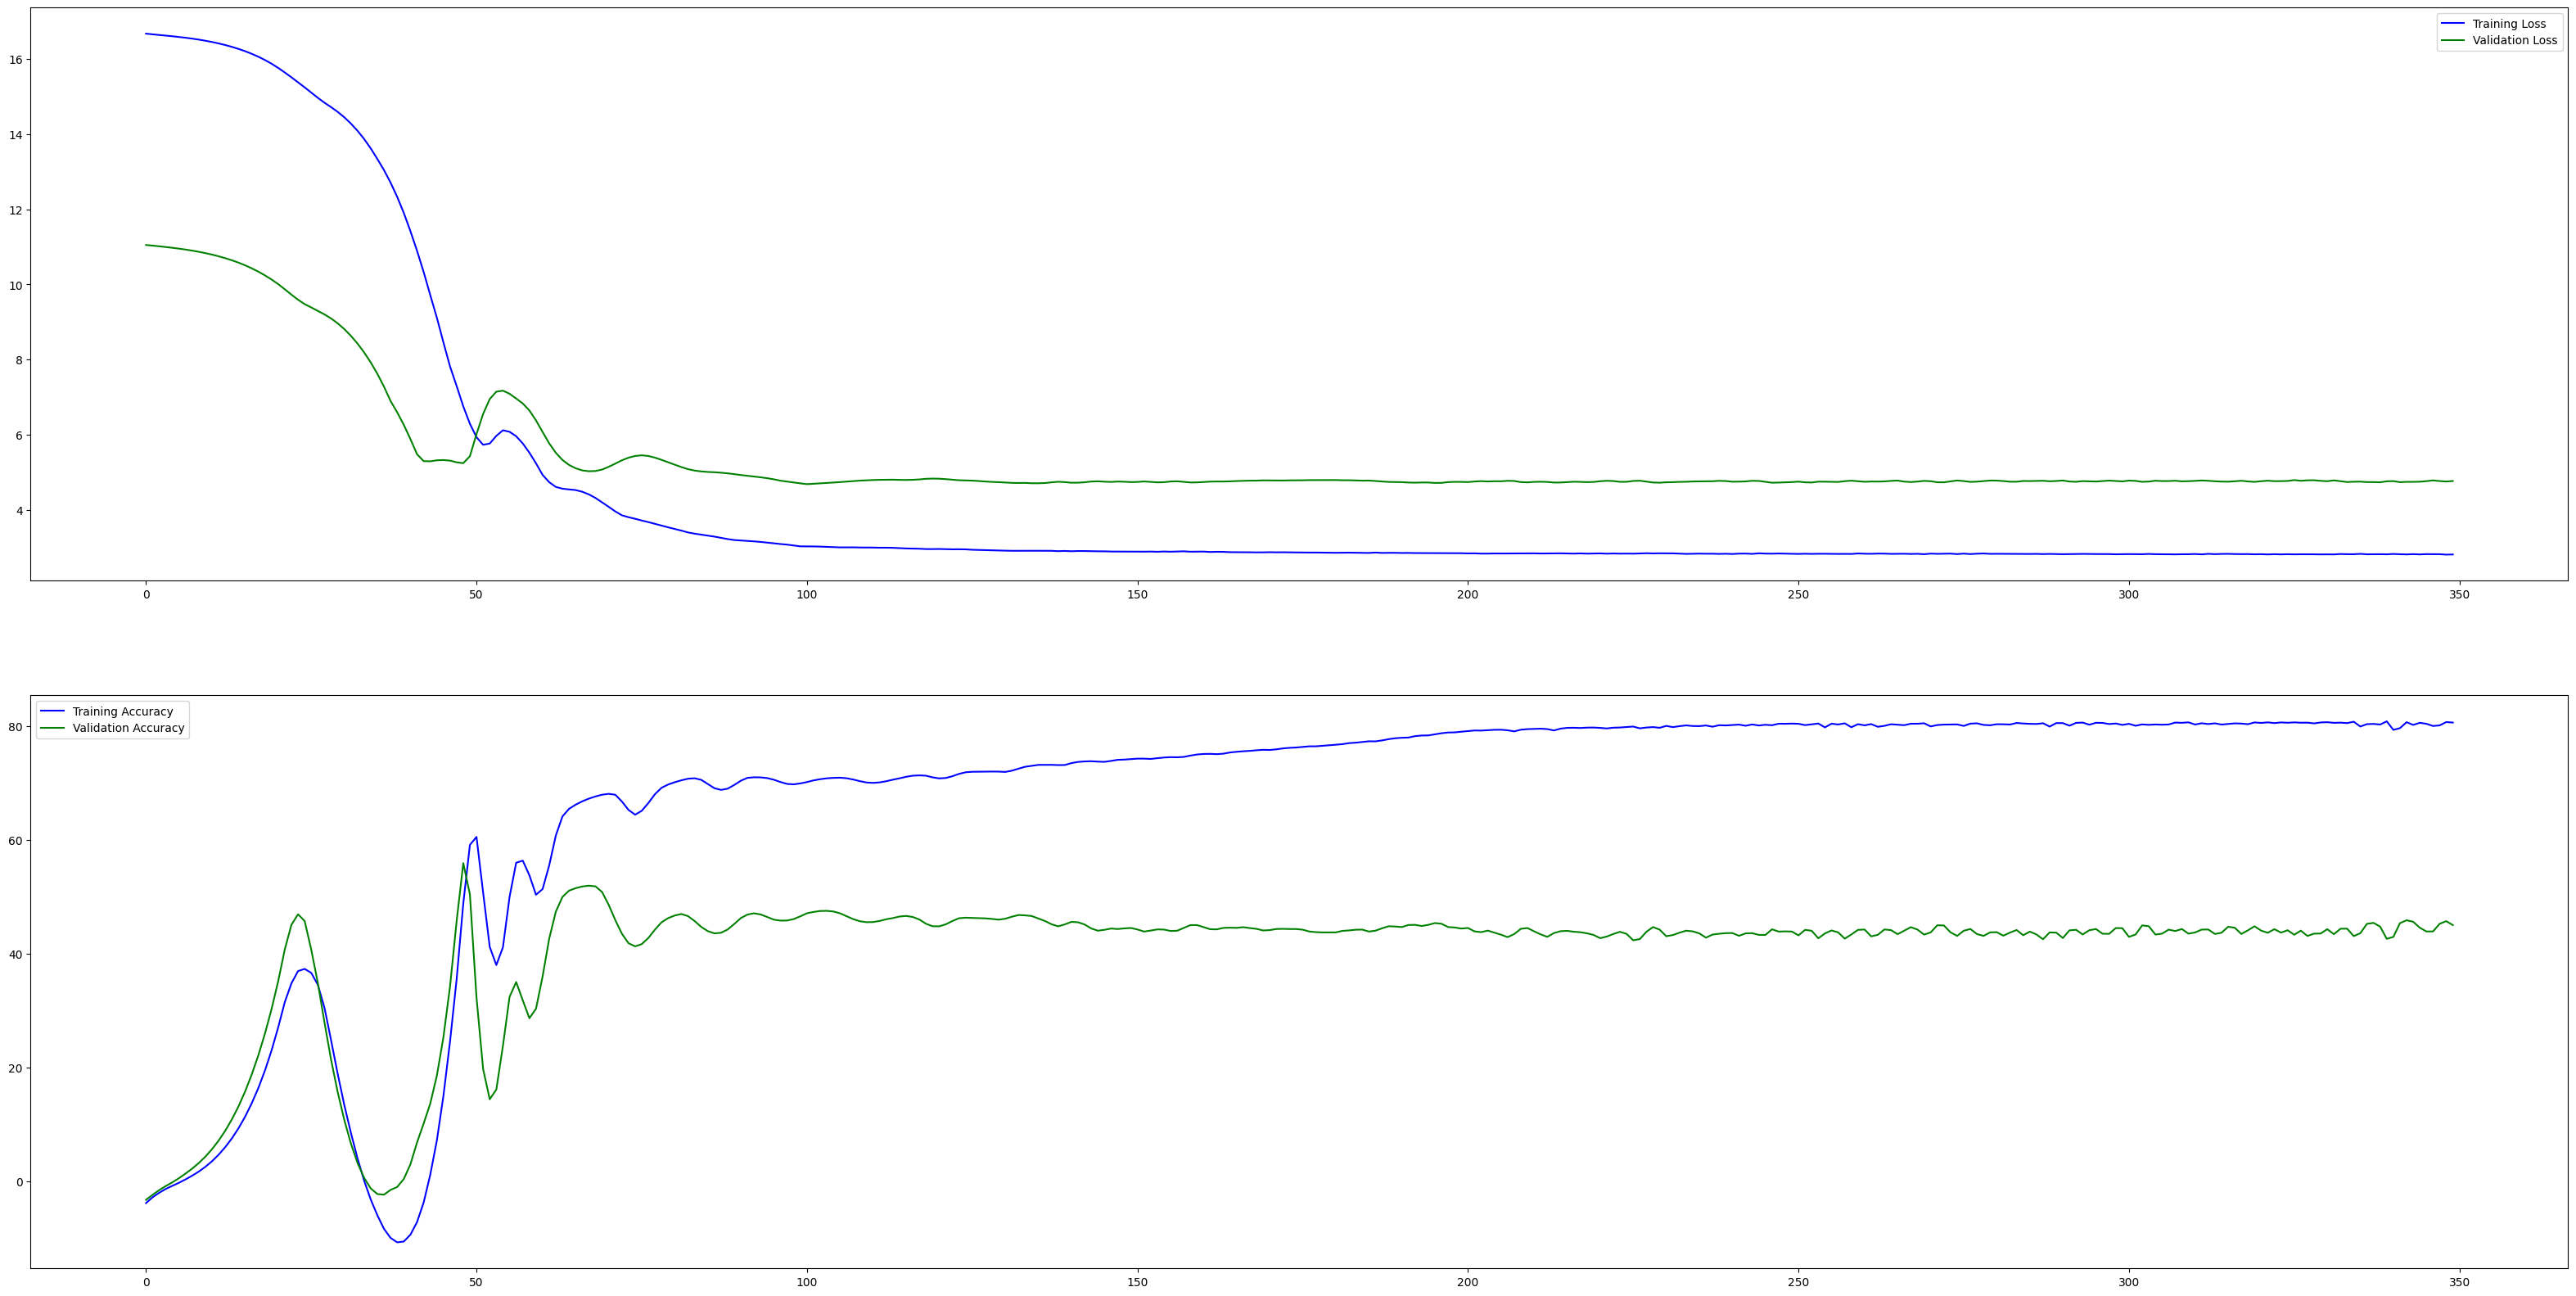

In [24]:
# Train the model
model = KneePointGCN(features=9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.L1Loss()
epochs = 350
hist = train(model=model, train_data=train_data, val_data=val_data, test_data=test_data, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs)
plot_losses(training_losses=hist['train_losses'], training_accuracies=hist['train_accuracies'], test_accuracies=hist['test_accuracies'], test_losses=hist['test_losses'], val_accuracies=hist['val_accuracies'], val_losses=hist['val_losses'], epochs=epochs, save_path='/home/sgl57/CSE_MSE_RXF131/cradle-members/mds3/sgl57/24-ceramics-rishi/topics/GNN')

By combining ZrO2 and YSZ subgraphs, the model's initial results has shown a decrease in performance.
Due to YSZ and ZrO2 taking up majority of the dataset, combining their subgraph likely has the effects of overfitting to this particular subgraph and lose the overall generality of the model, therefore deteriorates overall performance.